# WORKFLOW FOR CLOSED LOOP DESIGN

This notebook illustrates the structure of your final project.

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install tellurium
    !pip -q install control

In [2]:
from controlSBML import ControlSBML, constants

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

In [4]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 ->; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model.

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       NamedArray
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is None:
        data = rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        data = rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return data

# TESTS
data = plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
assert(len(data) > 0)
print("OK!")

OK!


In [6]:
def buildPITestbed(model, input_name, output_name, sign=1):
    """
    Creates an Antimony model of a PI controller using model as the open loop system.
    The resulting model as Antimony parameters for the setpoint, kP, kI. Assumes that
    this is a modular model (has an "end" statement).

    Args:
        model: str (Antimony model of OLS)
        input_name: str (name of a species in the OLS)
        output_name: str (name of a species in the OLS)
        sign: int (directional effect of input on output)

    Returns:
        str (Antimony model)
    """
    # Control codes
    control_logic = """
        // Parameters in CLS
        setpoint = 1
        kP = 1
        kI = 0
        sign = {sign}

        // Controller
        control_error := sign*(setpoint - {output_name})
        integral_control_error = 0
        integral_control_error' = control_error
        ${input_name} := kP*control_error + kI*integral_control_error
        """
    # Partition the model
    try:
        end_pos = model.index("end")
    except:
        end_pos = len(model) - 1
    model_front = model[:end_pos]
    model_back = model[end_pos:]
    return model_front + control_logic.format(input_name=input_name, output_name=output_name, sign=sign) + model_back

# TESTS
is_plot = False
cl_model = buildPITestbed(TEST_MODEL, "S1", "S3")
rr = te.loada(cl_model)
rr["kP"] = 10
rr["kI"] = 5
rr["setpoint"] = 8
rr.simulate(0, 10, 100, selections=["time", "setpoint", "S3"])
if is_plot:
    rr.plot()
print("OK!")

OK!


# 1. Problem statement and system definition

## Problem statement

The biological problem we address is controlling the concentration of pyruvate, ``s5`` in the Wolf model of glycolytic oscillations.  Our control objectives are:
* Regulate ``pyruvate` to a setpoint
* Fast settling times
* Avoid oscillations

## System definition

The system we analyze has the following characteristics:
1. SBML model: BIOMDELS 206
1. output: na (NADP)
1. input: s5 (pyruvate)
1. directional effect of the input on the output: increasing (See below.)
1. operating region for the input: [0.5, 1] (See below.)
1. range of outputs that can be achieved: [8, 11]  (See below.)

In [22]:
# Global variables
INPUT_NAME = "na"
OUTPUT_NAME = "s5"
CTLSB = ControlSBML(WOLF_URL, input_names=[INPUT_NAME], output_names=[OUTPUT_NAME], times=TIMES)

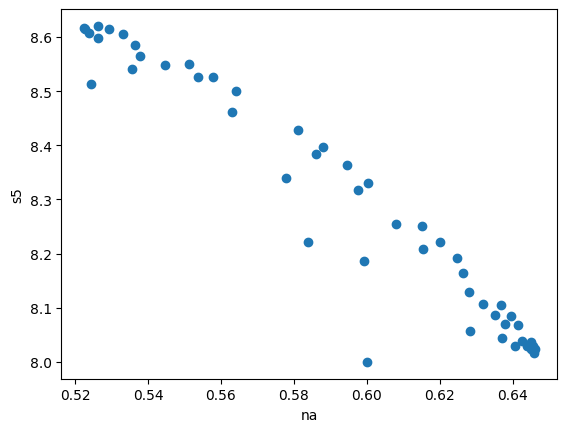

In [21]:
# Plot the relationship between the input and output at the same times
ts = CTLSB.plotModel(is_plot=False)
df = ts[[INPUT_NAME, OUTPUT_NAME]]
inputs = df[INPUT_NAME]
outputs = df[OUTPUT_NAME]
plt.scatter(inputs, outputs)
plt.xlabel(INPUT_NAME)
plt.ylabel(OUTPUT_NAME)
if False:
    seconds = np.array(df.index)/1e3
    plt.plot(seconds, df[INPUT_NAME])
    plt.plot(seconds, df[OUTPUT_NAME])
    plt.xlabel("time")

The input and output seem to be related within the simulation. We can learn more by controlling the input to see the effect on the output.

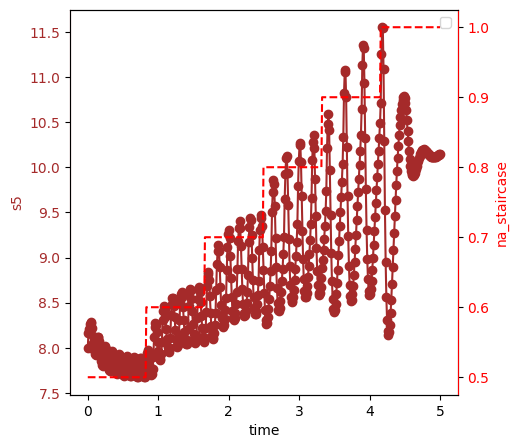

In [9]:
_ = CTLSB.plotStaircaseResponse(initial_value=0.5, final_value=1)

Clearly, the effect of the input ``na`` causes the output ``s5`` to increase. However, there is an initial transient, sustained oscillations, and a value of ``na`` that is larger than 1.0 has not effect. The output range is [8, 11.5].

The initial transient is likely related to initial conditions set by the model. We can ignore this since they disappear after a few hundred seconds.

# 2. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``na`` and the output is ``s5``. The input is varied over the operating region of [0.5, 1]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit.

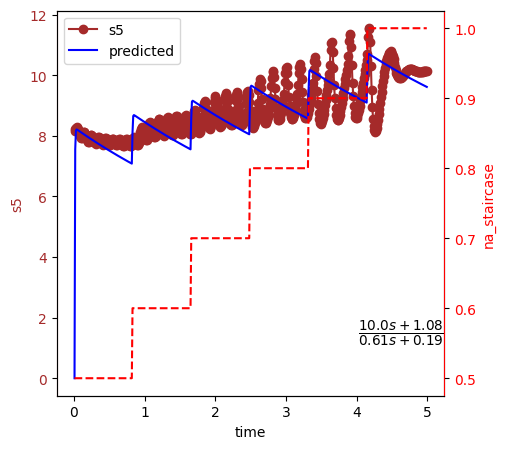

In [25]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=0.5, final_value=1.0)

In [27]:
TRANSFER_FUNCTION = (10*s + 1.08)/(0.61*s + 0.19)
TRANSFER_FUNCTION

TransferFunction(array([10.  ,  1.08]), array([0.61, 0.19]))

In [12]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-248.37587859+0.j,   -0.30738898+0.j]), array([-0.10810185+0.j]))

# 3. Control design


## Testbed construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. We use a PI controller. We examine both the output response and the value of the input. The latter is to ensure that we are within the operating region.

In [13]:
antimony = CTLSB.getAntimony()
WOLF_CL = buildPITestbed(antimony, INPUT_NAME, OUTPUT_NAME, sign=1)

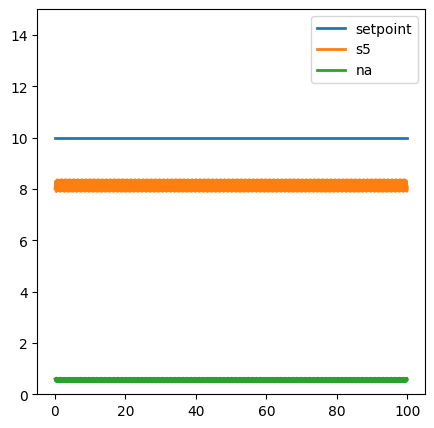

In [33]:
_ = plotModel(WOLF_CL, title="", selections=["setpoint", "s5", "na"],
              setpoint=10, kP=0.3, kI=0, ylim=[0, 15], times=np.linspace(0, 100, 1000))

We are able to simulate the closed loop system, but it's not easy to find design parameters that meet our control objectives.

## Root locus analysis

P Controller

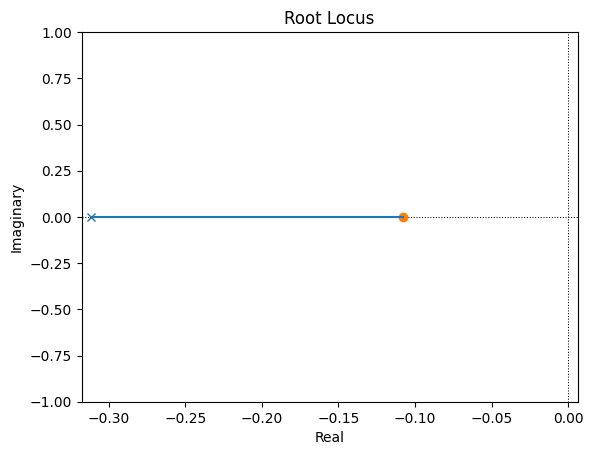

In [29]:
_ = control.root_locus(TRANSFER_FUNCTION, grid=False)

This plot tells us that P-control will generally result in a slow system. It doesn't explain the oscillations in the simulation since the fitted transfer function does not have oscillations.

I Controller

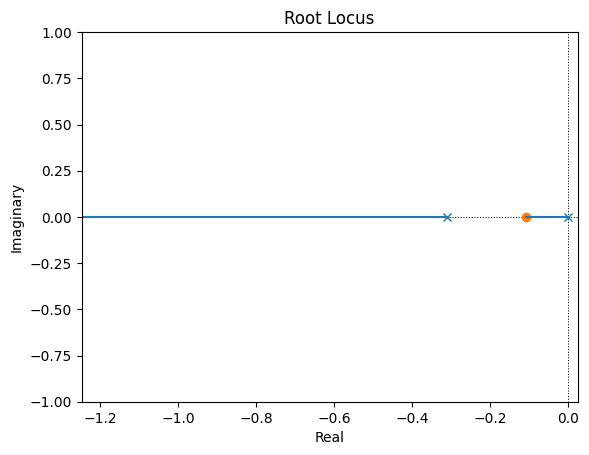

In [28]:
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

This plot suggests that I control can make the system faster because we move the dominant pole from 0 to -0.2.

## Grid Search

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.252928 and h = 2.45143e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0476264 and h = 7.67677e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0322677 and h = 6.23727e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0248779 and h = 1.89827e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0203394 and h = 1.97418e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, M

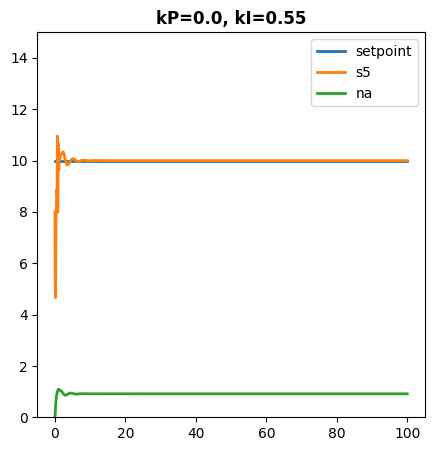

In [16]:
# Set the search parameters and initialize
setpoint = 10
best_rmse = 1e6
best_ks = []
kPs = [0.05*n for n in range(20)]
kIs = [0.05*n for n in range(20)]
# Do the grid search
for kI in kIs:
    for kP in kPs:
        try:
            data = plotModel(WOLF_CL, title="", selections=["setpoint", "s5", "na"], is_plot=False,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0, 15], times=np.linspace(0, 100, 1000))
        except:
            continue
        outputs = data[OUTPUT_NAME]
        rmse = np.sum((setpoint - outputs)**2)
        if rmse < best_rmse:
            best_mse = rmse
            best_ks = [kP, kI]
# Report the results
if len(best_ks) == 0:
    print("\n***No design found.")
else:
    kP = best_ks[0]
    kI = best_ks[1]
    title = "kP={kP}, kI={kI}".format(kP=kP, kI=kI)
    _ = plotModel(WOLF_CL, selections=["setpoint", "s5", "na"], is_plot=True,
                      setpoint=setpoint, kP=kP, kI=kI, ylim=[0, 15], 
                  times=np.linspace(0, 100, 1000), title=title)

# 4. Discussion

This section discusses issues encountered in the design.